In [60]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display

p2_path = "/Users/shari/Desktop/GPP_GPS_FanDuel_DA_CaseStudyAssessment_v1/GPP_Fanduel_CaseStudy_BusinessDataAnalysis_p2.csv"
p1_path = "/Users/shari/Desktop/GPP_GPS_FanDuel_DA_CaseStudyAssessment_v1/GPP_FanDuel_CaseStudy_BusinessDataAnalysis_p1.csv"

p2 = pd.read_csv(p2_path)
p1 = pd.read_csv(p1_path)

(p2.head(), list(p2.columns), p1.head(), list(p1.columns))

(   PlayerID        Date     Handle      GGR Last _12Months_Segment  \
 0   1230877  11/24/2019  1104750.0 -49000.0                   high   
 1   1230877  11/26/2019   596214.0 -30336.0                   high   
 2   1230877  11/13/2019   465250.0 -36000.0                   high   
 3   1230877   11/1/2019   437800.0 -20000.0                   high   
 4   1276799   2/24/2019   435275.0  69825.0                    vip   
 
   Target/Control  Bonus Awarded Post Promo In Analysis  
 0         Target           20.0         No          No  
 1         Target           20.0         No          No  
 2         Target           20.0         No          No  
 3         Target           20.0         No          No  
 4         Target           50.0         No          No  ,
 ['PlayerID',
  'Date',
  'Handle',
  'GGR',
  'Last _12Months_Segment',
  'Target/Control',
  'Bonus Awarded',
  'Post Promo',
  'In Analysis'],
    playerid      date    handle     ggr last_12months_segment Target/CG  \
 

In [61]:
# --- Standardize and clean raw dataframes from the two CSVs ---
def clean_df(df, schema='p2'):
    d = df.copy()

    # 1) Normalize column names: lowercase + underscores (handles spaces and hyphens)
    d.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in d.columns]

    # 2) Map common header variations to a consistent schema
    rename_map = {
        'target/cg': 'target_control',
        'target/control': 'target_control',
        'bonus_awarded': 'bonus_awarded',
        'bonus_award': 'bonus_awarded',
        'bonus awarded': 'bonus_awarded',
        'post_promo': 'post_promo',
        'in_analysis': 'in_analysis',
        'in-analysis': 'in_analysis',
        'last__12months_segment': 'last_12months_segment',
        'last_12months_segment': 'last_12months_segment',
        'playerid': 'player_id',
        'date': 'date',
        'ggr': 'ggr',
        'handle': 'handle',
    }
    d = d.rename(columns=rename_map)

    # 3) Coerce numeric fields to numbers (invalids -> NaN) to ensure arithmetic works later
    for col in ['ggr', 'handle', 'bonus_awarded']:
        if col in d.columns:
            d[col] = pd.to_numeric(d[col], errors='coerce')

    # 4) Parse dates (invalids -> NaT) for window diagnostics and time-based grouping
    if 'date' in d.columns:
        d['date'] = pd.to_datetime(d['date'], errors='coerce')

    # 5) Standardize Post/Pre flag as boolean: 'yes' -> True, 'no' -> False
    if 'post_promo' in d.columns:
        d['post_promo'] = (
            d['post_promo']
            .astype(str).str.strip().str.lower()
            .map({'yes': True, 'no': False})
        )

    # 6) Standardize group labels; e.g., 'control group' -> 'control'
    if 'target_control' in d.columns:
        d['target_control'] = (
            d['target_control']
            .astype(str).str.strip().str.lower()
            .replace({'control group': 'control'})
        )

    return d

cp2 = clean_df(p2)
cp1 = clean_df(p1)

# Inspect the unique values for 'target_control' and 'post_promo' in both datasets.
cp2['target_control'].dropna().unique(), cp2['post_promo'].dropna().unique(), \
cp1['target_control'].dropna().unique(), cp1['post_promo'].dropna().unique()


(array(['target', 'control'], dtype=object),
 array([False,  True]),
 array(['target', 'control'], dtype=object),
 array([ True, False]))

In [62]:
# Window diagnostics: pre vs post coverage (justification for post-only ROI)
# Summarize the temporal coverage of the dataset by group (Target/Control) and period (Pre/Post).
# If the PRE window spans many more days than the POST window (promo day),
# comparing totals (e.g., total GGR) is not equivalant.
# Therefore prefer a post-only per-player ROI read-out (and/or matched-window DiD).

def window_diag(d):
    # Group by cohort and period, then compute:
    # - min/max activity date (window bounds)
    # - days covered (inclusive)
    # - number of rows (transactions/records)
    # - number of distinct players
    tmp = (
        d.groupby(['target_control', 'post_promo'])
         .agg(
             min_date=('date', 'min'),                         # earliest activity date in the group/period
             max_date=('date', 'max'),                         # latest activity date in the group/period
             days=('date', lambda s: (s.max() - s.min()).days + 1),  # inclusive span in days (add 1)
             rows=('date', 'size'),                            # count of rows (activity lines)
             players=('player_id', 'nunique')                  # distinct players contributing
         )
         .reset_index()
    )
    return tmp

window_summary = window_diag(cp2)

# Compare PRE (post_promo=False) vs POST (post_promo=True) by group.
window_summary


,target_control,post_promo,min_date,max_date,days,rows,players
0,control,False,2019-01-21,2020-01-20,365,2191,138
1,control,True,2020-01-21,2020-02-06,17,145,34
2,target,False,2019-01-21,2020-01-20,365,9279,540
3,target,True,2020-01-21,2020-02-06,17,566,103


In [63]:
# --- Summarize date coverage and window length by cohort (Target/Control) and period (Pre/Post) ---
def window_diag(df):
    # Group by cohort and period, then compute:
    #  - min_date / max_date: bounds of activity in that window
    #  - days: inclusive span (max - min + 1 day) to avoid off-by-one
    #  - rows: number of records (activity lines) in that window
    tmp = (
        df.groupby(['target_control', 'post_promo'])
          .agg(
              min_date=('date', 'min'),
              max_date=('date', 'max'),
              days=('date', lambda s: (s.max() - s.min()).days + 1),
              rows=('date', 'size')
          )
          .reset_index()
    )
    return tmp

window_summary = window_diag(cp2)
window_summary
# justify post-only per-player ROI when windows are unequal


,target_control,post_promo,min_date,max_date,days,rows
0,control,False,2019-01-21,2020-01-20,365,2191
1,control,True,2020-01-21,2020-02-06,17,145
2,target,False,2019-01-21,2020-01-20,365,9279
3,target,True,2020-01-21,2020-02-06,17,566


In [64]:
# --- Audit for potential bonus double-counting at the transaction level ---
# Bonus is awarded ONCE per player, but can appear on multiple rows (e.g., multiple activity records).
# If performing a sum 'bonus_awarded' over transactions, may overstate spend.
# How many times bonus appears per player and summarizes duplication patterns.

def bonus_duplication_report(df):
    # Count how many rows each player contributes (helps spot very active players)
    rows_per_player = (
        df.groupby('player_id').size().rename('row_count')
    )

    # Sum of 'bonus_awarded' per player ACROSS ALL ROWS (will overcount if the same bonus repeats).
    # min_count=1 preserves NaN when a player has only NaNs (instead of returning 0).
    bonus_by_player = (
        df.groupby('player_id')['bonus_awarded']
          .sum(min_count=1).rename('bonus_sum')
    )

    # How many DISTINCT non-null bonus values appear?
    # Expected = 1 (one denomination per player)
    # Value >1 used to flag inconsistent data
    bonus_distinct = (
        df.dropna(subset=['bonus_awarded'])
          .groupby('player_id')['bonus_awarded']
          .nunique()
          .rename('bonus_unique_values')
    )

    # First non-null bonus per player (intended "one bonus per player" value to use downstream).
    first_bonus = (
        df.groupby('player_id')['bonus_awarded']
          .apply(lambda s: s.dropna().iloc[0] if s.dropna().size else np.nan)
          .rename('bonus_first')
    )

    # Count of non-null bonus entries per player (how many rows have a bonus value)
    # Expected = 1
    # Value >1 indicates the SAME bonus appears in multiple rows (duplication risk)
    bonus_nonnull_count = (
        df.groupby('player_id')['bonus_awarded']
          .apply(lambda s: s.notna().sum())
          .rename('bonus_nonnull_count')
    )

    rep = pd.concat(
        [rows_per_player, bonus_nonnull_count, bonus_distinct, first_bonus, bonus_by_player],
        axis=1
    )
    return rep

rep2 = bonus_duplication_report(cp2)
rep1 = bonus_duplication_report(cp1)

# Flag players whose bonus appears on more than one row (duplication indicator)
rep2['repeated_bonus_rows'] = rep2['bonus_nonnull_count'] > 1
rep1['repeated_bonus_rows'] = rep1['bonus_nonnull_count'] > 1

# Aggregate the flags to see how common duplication is (True/False counts)
rep2_summary = rep2['repeated_bonus_rows'].value_counts(dropna=False)
rep1_summary = rep1['repeated_bonus_rows'].value_counts(dropna=False)

rep2_summary, rep1_summary


(False    409
 True     290
 Name: repeated_bonus_rows, dtype: int64,
 False    409
 True     290
 Name: repeated_bonus_rows, dtype: int64)

In [65]:
# --- Helper to compute BONUS SPEND once per player within a period (avoid double counting) ---
def sum_unique_bonus(df_period):
    # Only keep rows where a bonus value is present
    d = df_period.dropna(subset=['bonus_awarded']).copy()
    # For each player, take the FIRST non-null bonus value seen in this period.
    # Assumption: each player should receive exactly one bonus denomination (per business rules).
    # If multiple different bonus values exist for a player, will pick the first encountered.
    bonus_per_player = (
        d.groupby('player_id')['bonus_awarded']
         .apply(lambda s: s.iloc[0])
         .rename('bonus_one_per_player')
    )
    # Total promo spend in this window = sum of one bonus per unique player
    return bonus_per_player.sum()


def summarize_group_periods(df):
    out = []
    for grp in ['control', 'target']:
        d = df[df['target_control'] == grp]
        for post_flag, label in [(False, 'pre'), (True, 'post')]:
            dd = d[d['post_promo'] == post_flag]

            # Aggregate core KPIs for this group-period window
            ggr_sum = dd['ggr'].sum()                    # total GGR in the window (pre-bonus)
            handle_sum = dd['handle'].sum()              # total handle in the window
            players = dd['player_id'].nunique()          # distinct players contributing in the window

            # Sum promo spend ONCE per player (pre should typically be 0; if not, then data anomaly)
            bonus_sum = sum_unique_bonus(dd)

            out.append({
                'group': grp,
                'period': label,
                'players': players,
                'handle_sum': handle_sum,
                'ggr_sum': ggr_sum,
                'bonus_sum_unique_players': bonus_sum
            })
    return pd.DataFrame(out)

summary_p2 = summarize_group_periods(cp2)
summary_p1 = summarize_group_periods(cp1)

summary_p2, summary_p1


/var/folders/cz/dgb3tl0j0dv_z900spvfm6p40000gn/T/ipykernel_72383/1918981649.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda s: s.iloc[0])
/var/folders/cz/dgb3tl0j0dv_z900spvfm6p40000gn/T/ipykernel_72383/1918981649.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lam

(     group period  players   handle_sum    ggr_sum  bonus_sum_unique_players
 0  control    pre      138   2610709.53  104819.49                       0.0
 1  control   post       34    102824.83    5941.82                       0.0
 2   target    pre      540  20823713.70  516855.48                    3910.0
 3   target   post      103   1270082.08    5826.55                    1105.0,
      group period  players   handle_sum    ggr_sum  bonus_sum_unique_players
 0  control    pre      138   2610709.53  104819.49                       0.0
 1  control   post       34    102824.83    5941.82                       0.0
 2   target    pre      540  20823713.70  516855.48                    3910.0
 3   target   post      103   1270082.08    5826.55                    1105.0)

In [66]:
# --- Post-period portion (promo window only) ---
post = cp2[cp2['post_promo'] == True].copy()

# --- Total bonus in post-period: count ONE bonus per player (avoid double counting across rows) ---
bonus_post_total = (
    post.dropna(subset=['bonus_awarded'])
        .groupby('player_id')['bonus_awarded']
        .apply(lambda s: s.iloc[0])
        .sum()
)

# --- Aggregate core KPIs by cohort (Target vs Control) for the post-period ---
post_group = (
    post.groupby('target_control')
        .agg(
            players=('player_id', 'nunique'),  # distinct players in post window
            ggr_sum=('ggr', 'sum'),            # total GGR (pre-bonus)
            handle_sum=('handle', 'sum')       # total handle
        )
        .reset_index()
)

# --- Per-player GGR (when group sizes differ) ---
post_group['ggr_per_player'] = post_group['ggr_sum'] / post_group['players']

# --- Bonus totals by cohort in post portion (Control should be 0; Target has one bonus per player) ---
#     Step 1: get one bonus per (group, player)
#     Step 2: sum across players by group
#     Step 3: reindex to ensure ['control','target'] order and fill any missing with 0.0
post_bonus_by_group = (
    post.dropna(subset=['bonus_awarded'])
        .groupby(['target_control','player_id'])['bonus_awarded'].first()
        .groupby('target_control').sum()
        .reindex(['control','target'])
        .fillna(0.0)
)

# --- Attach cohort bonus totals back to the group summary ---
post_group['bonus_sum'] = post_group['target_control'].map(post_bonus_by_group)

# --- Net Gaming Revenue (after bonus) and per-player net ---
post_group['ngr_sum'] = post_group['ggr_sum'] - post_group['bonus_sum']          # NGR = GGR - Bonus
post_group['ngr_per_player'] = post_group['ngr_sum'] / post_group['players']     # per-player NGR

post_group


,target_control,players,ggr_sum,handle_sum,ggr_per_player,bonus_sum,ngr_sum,ngr_per_player
0,control,34,5941.82,102824.83,174.759412,0.0,5941.82,174.759412
1,target,103,5826.55,1270082.08,56.568447,1105.0,4721.55,45.840291


In [67]:
# --- KPI breakdown by value tier (within post-period only) ---
post_tier = (
    post.groupby(['target_control', 'last_12months_segment'])
        .agg(
            players=('player_id', 'nunique'),  # distinct players in this group/tier
            ggr_sum=('ggr', 'sum'),            # total GGR (pre-bonus) for the tier
            handle_sum=('handle', 'sum')       # total handle for the tier
        )
        .reset_index()
)

# --- Compute BONUS per tier: count ONE bonus per player, then sum across players in each (group, tier) ---
bonus_post_tier = (
    post.dropna(subset=['bonus_awarded'])
        .groupby(['target_control', 'last_12months_segment', 'player_id'])['bonus_awarded']
        .first()                                 # one bonus per (group, tier, player)
        .groupby(['target_control', 'last_12months_segment'])
        .sum()                                   # total bonus spend for the (group, tier)
)

# --- Attach tier bonus totals back to the KPI table ---
#     Map the MultiIndex (group, tier) sums onto the same index in post_tier
#     Fill groups/tiers with no bonus awarded (e.g., control) as 0.0.
post_tier['bonus_sum'] = (
    post_tier.set_index(['target_control', 'last_12months_segment'])
             .index.map(bonus_post_tier)        # aligns by (group, tier)
             .astype(float)
)
post_tier['bonus_sum'] = post_tier['bonus_sum'].fillna(0.0)

# --- Net Gaming Revenue and per-player KPIs by tier ---
post_tier['ngr_sum'] = post_tier['ggr_sum'] - post_tier['bonus_sum']     # NGR = GGR - Bonus
post_tier['ggr_per_player'] = post_tier['ggr_sum'] / post_tier['players']
post_tier['ngr_per_player'] = post_tier['ngr_sum'] / post_tier['players']

post_tier_sorted = post_tier.sort_values(['target_control', 'last_12months_segment'])

display("Post-period KPI by Group & Tier", post_tier_sorted)

post_group


'Post-period KPI by Group & Tier'

,target_control,last_12months_segment,players,ggr_sum,handle_sum,bonus_sum,ngr_sum,ggr_per_player,ngr_per_player
0,control,high,3,-194.63,25850.30,0.0,-194.63,-64.876667,-64.876667
1,control,low,18,1972.01,20810.14,0.0,1972.01,109.556111,109.556111
2,control,medium,7,2751.38,43060.53,0.0,2751.38,393.054286,393.054286
3,control,no bet,1,25.12,211.70,0.0,25.12,25.120000,25.120000
4,control,regnodep,4,50.00,997.81,0.0,50.00,12.500000,12.500000
5,control,vip,1,1337.94,11894.35,0.0,1337.94,1337.940000,1337.940000
6,target,high,14,9446.48,304771.32,280.0,9166.48,674.748571,654.748571
7,target,low,52,7915.53,113180.70,260.0,7655.53,152.221731,147.221731
8,target,medium,22,-1871.16,236272.30,220.0,-2091.16,-85.052727,-95.052727
9,target,no bet,1,0.00,0.00,5.0,-5.00,0.000000,-5.000000


,target_control,players,ggr_sum,handle_sum,ggr_per_player,bonus_sum,ngr_sum,ngr_per_player
0,control,34,5941.82,102824.83,174.759412,0.0,5941.82,174.759412
1,target,103,5826.55,1270082.08,56.568447,1105.0,4721.55,45.840291


# validate bonus awarded per value tier

In [68]:
# Check unique bonus values awarded per tier in post-promo Target
bt = post[(post['target_control']=='target') & post['bonus_awarded'].notna()]
bonus_by_tier = bt.groupby('last_12months_segment')['bonus_awarded'].unique().apply(lambda x: sorted(pd.Series(x).dropna().unique()))
bonus_by_tier_df = bonus_by_tier.reset_index(name='unique_bonus_values')
bonus_by_tier_df

,last_12months_segment,unique_bonus_values
0,high,[20.0]
1,low,[5.0]
2,medium,[10.0]
3,no bet,[5.0]
4,regnodep,[5.0]
5,vip,[50.0]


# net margin after bonus (% of GGR) with safe handling

In [69]:
# --- Safe net margin after bonus (% of GGR) for cohort-level POST summary ---
# net_margin_after_bonus_pct = (GGR - Bonus) / GGR
# Why is it called safe net margin?
# When GGR <= 0, ratio can be misleading (>100% or sign-flipped),
# so explicitly return NaN in those cases and rely on NGR ($) instead.

def net_margin_after_bonus_pct(ggr, bonus):
    # Guard against missing values and non-positive GGR
    # - If GGR is NaN or <= 0, return NaN (avoid dividing by zero or producing confusing %)
    # - If Bonus is NaN, also return NaN (incomplete data)
    if pd.isna(ggr) or pd.isna(bonus) or ggr <= 0:
        return np.nan
    # Compute margin as the share of GGR remaining after bonuses
    return (ggr - bonus) / ggr

# Apply the safe margin to each row of post_group, which contains:
# - ggr_sum: total GGR for the cohort in POST
# - bonus_sum: total bonus spend for the cohort in POST (one bonus per player)
post_group['net_margin_after_bonus_pct'] = post_group.apply(
    lambda r: net_margin_after_bonus_pct(r['ggr_sum'], r['bonus_sum']), axis=1
)

# Validate the calculation and interpretation:
# - target_control: cohort label (control/target)
# - ggr_sum: pre-bonus revenue
# - bonus_sum: promo spend
# - ngr_sum: net revenue after bonus (GGR - Bonus)
# - net_margin_after_bonus_pct: % of GGR left after bonuses (NaN if GGR <= 0)
post_group[['target_control','ggr_sum','bonus_sum','ngr_sum','net_margin_after_bonus_pct']]


,target_control,ggr_sum,bonus_sum,ngr_sum,net_margin_after_bonus_pct
0,control,5941.82,0.0,5941.82,1.000000
1,target,5826.55,1105.0,4721.55,0.810351


In [70]:
# --- Safe net margin after bonus (% of GGR) at the (group, tier) level ---
# Returns NaN when GGR <= 0 (to avoid misleading percentages), else (GGR - Bonus)/GGR.

post_tier['net_margin_after_bonus_pct'] = post_tier.apply(
    lambda r: net_margin_after_bonus_pct(r['ggr_sum'], r['bonus_sum']), axis=1
)

# Inspect per-tier fields to validate:
# - target_control / last_12months_segment: cohort & segment identifiers
# - ggr_sum: pre-bonus revenue for the tier
# - bonus_sum: total promo spend in the tier (one bonus per player)
# - ngr_sum: net revenue after bonus (GGR - Bonus)
# - net_margin_after_bonus_pct: % of GGR retained after bonus (NaN if GGR <= 0)
post_tier[['target_control','last_12months_segment','ggr_sum','bonus_sum','ngr_sum','net_margin_after_bonus_pct']]


,target_control,last_12months_segment,ggr_sum,bonus_sum,ngr_sum,net_margin_after_bonus_pct
0,control,high,-194.63,0.0,-194.63,NaN
1,control,low,1972.01,0.0,1972.01,1.000000
2,control,medium,2751.38,0.0,2751.38,1.000000
3,control,no bet,25.12,0.0,25.12,1.000000
4,control,regnodep,50.00,0.0,50.00,1.000000
5,control,vip,1337.94,0.0,1337.94,1.000000
6,target,high,9446.48,280.0,9166.48,0.970359
7,target,low,7915.53,260.0,7655.53,0.967153
8,target,medium,-1871.16,220.0,-2091.16,NaN
9,target,no bet,0.00,5.0,-5.00,NaN


In [71]:
# --- PRE-period window (before promo): set bonus to 0 as promos are post-period only ---
pre = cp2[cp2['post_promo'] == False].copy()

# --- Aggregate core KPIs by cohort (Target vs Control) for the PRE-period ---
pre_group = (
    pre.groupby('target_control')
       .agg(
           players=('player_id', 'nunique'),  # distinct players observed in PRE
           ggr_sum=('ggr', 'sum'),            # total GGR (pre-bonus by definition)
           handle_sum=('handle', 'sum')       # total handle
       )
       .reset_index()
)

# --- No promo spend in PRE; keep explicit column for symmetric schema ---
pre_group['bonus_sum'] = 0.0

# --- Net Gaming Revenue (NGR) equals GGR in PRE since bonus = 0 ---
pre_group['ngr_sum'] = pre_group['ggr_sum'] - pre_group['bonus_sum']

# --- Per-player metrics (control for cohort size differences) ---
pre_group['ggr_per_player'] = pre_group['ggr_sum'] / pre_group['players']
pre_group['ngr_per_player'] = pre_group['ngr_sum'] / pre_group['players']

pre_group


,target_control,players,ggr_sum,handle_sum,bonus_sum,ngr_sum,ggr_per_player,ngr_per_player
0,control,138,104819.49,2610709.53,0.0,104819.49,759.561522,759.561522
1,target,540,516855.48,20823713.70,0.0,516855.48,957.139778,957.139778


In [72]:
# --- PRE vs. POST change by cohort (totals and per-player) ---
# Goal is to quantify how GGR and NGR changed from PRE to POST for each cohort, using both raw totals and per-player rates (per-player is more comparable when cohort sizes differ).

# Join POST and PRE cohort summaries side-by-side on 'target_control'
chg = post_group[['target_control','players','ggr_sum','bonus_sum','ngr_sum']].merge(
    pre_group[['target_control','players','ggr_sum','bonus_sum','ngr_sum']],
    on='target_control',
    suffixes=('_post','_pre')
)

# % change on TOTALS: (post − pre) / pre
# sensitive to unequal window lengths
for col in ['ggr_sum','ngr_sum']:
    chg[f'{col}_pct_change'] = (chg[f'{col}_post'] - chg[f'{col}_pre']) / chg[f'{col}_pre']

# --- Per-player changes ---
# Per-player metrics for POST and PRE merged by cohort
post_pp = post_group[['target_control','ggr_per_player','ngr_per_player']].rename(
    columns={'ggr_per_player':'ggr_pp_post', 'ngr_per_player':'ngr_pp_post'}
)
pre_pp = pre_group[['target_control','ggr_per_player','ngr_per_player']].rename(
    columns={'ggr_per_player':'ggr_pp_pre', 'ngr_per_player':'ngr_pp_pre'}
)
chg_pp = post_pp.merge(pre_pp, on='target_control')

# % change on Per-player rates: (post_pp − pre_pp) / pre_pp
chg_pp['ggr_pp_pct_change'] = (chg_pp['ggr_pp_post'] - chg_pp['ggr_pp_pre']) / chg_pp['ggr_pp_pre']
chg_pp['ngr_pp_pct_change'] = (chg_pp['ngr_pp_post'] - chg_pp['ngr_pp_pre']) / chg_pp['ngr_pp_pre']

display(
    "Group-level pre vs post changes (totals and per-player)",
    pd.concat([chg, chg_pp.drop(columns=['ggr_pp_post','ggr_pp_pre','ngr_pp_post','ngr_pp_pre'])], axis=1)
)


'Group-level pre vs post changes (totals and per-player)'

,target_control,players_post,ggr_sum_post,bonus_sum_post,ngr_sum_post,players_pre,ggr_sum_pre,bonus_sum_pre,ngr_sum_pre,ggr_sum_pct_change,ngr_sum_pct_change,target_control,ggr_pp_pct_change,ngr_pp_pct_change
0,control,34,5941.82,0.0,5941.82,138,104819.49,0.0,104819.49,-0.943314,-0.943314,control,-0.769921,-0.769921
1,target,103,5826.55,1105.0,4721.55,540,516855.48,0.0,516855.48,-0.988727,-0.990865,target,-0.940898,-0.952107


# retention/attrition of players

In [73]:
# --- Player retention/attrition by cohort (Target vs Control) ---
# Goal is to quantify how player counts changed from PRE to POST, per cohort.

players_pre  = pre_group.set_index('target_control')['players']   # distinct players in PRE
players_post = post_group.set_index('target_control')['players']  # distinct players in POST

# Retention rate = Post players / Pre players (share of players who remained active)
retention = (players_post / players_pre).rename('retention_rate')

# Attrition rate = 1 - retention (share of players lost)
attrition = (1 - retention).rename('attrition_rate')

ret_table = pd.concat(
    [
        players_pre.rename('pre_players'),
        players_post.rename('post_players'),
        retention,
        attrition
    ],
    axis=1
).reset_index()

ret_table


,target_control,pre_players,post_players,retention_rate,attrition_rate
0,control,138,34,0.246377,0.753623
1,target,540,103,0.190741,0.809259


In [74]:
# --- Difference-in-Differences (DiD) on per-player GGR and NGR ---
# Compare the change from PRE to POST in Target vs the change from PRE to POST in Control.
# DiD (per-player) = (Target_post_pp - Target_pre_pp) - (Control_post_pp - Control_pre_pp).

# Per-player PRE vs. POST deltas for each cohort (Control, Target) on GGR
control_delta_ggr_pp = (
    chg_pp.loc[chg_pp['target_control'] == 'control', 'ggr_pp_post'].values[0]
    - chg_pp.loc[chg_pp['target_control'] == 'control', 'ggr_pp_pre'].values[0]
)
target_delta_ggr_pp  = (
    chg_pp.loc[chg_pp['target_control'] == 'target', 'ggr_pp_post'].values[0]
    - chg_pp.loc[chg_pp['target_control'] == 'target', 'ggr_pp_pre'].values[0]
)
# DiD per-player GGR: Target's change - Control's change
did_ggr_pp = target_delta_ggr_pp - control_delta_ggr_pp

# Repeat for NGR per player
control_delta_ngr_pp = (
    chg_pp.loc[chg_pp['target_control'] == 'control', 'ngr_pp_post'].values[0]
    - chg_pp.loc[chg_pp['target_control'] == 'control', 'ngr_pp_pre'].values[0]
)
target_delta_ngr_pp  = (
    chg_pp.loc[chg_pp['target_control'] == 'target', 'ngr_pp_post'].values[0]
    - chg_pp.loc[chg_pp['target_control'] == 'target', 'ngr_pp_pre'].values[0]
)
# DiD per-player NGR
did_ngr_pp = target_delta_ngr_pp - control_delta_ngr_pp

# --- Scale per-player DiD to total incremental impact in the POST window ---
# Multiply per-player lift by the number of Target players observed in POST.
target_post_players = post_group.loc[post_group['target_control'] == 'target', 'players'].values[0]
inc_ggr_total = did_ggr_pp * target_post_players   # total incremental GGR (DiD-based) in POST
inc_ngr_total = did_ngr_pp * target_post_players   # total incremental NGR (DiD-based) in POST

# --- ROI based on DiD incremental impacts ---
# Compare incremental GGR/NGR to the Target's POST bonus spend (one bonus per player).
bonus_post_target = post_group.loc[post_group['target_control'] == 'target', 'bonus_sum'].values[0]

# ROI using incremental GGR against bonus: (Inc GGR - Bonus) / Bonus
roi_inc_ggr = (
    (inc_ggr_total - bonus_post_target) / bonus_post_target
    if bonus_post_target != 0 else np.nan
)

# ROI using incremental NGR against bonus: Inc NGR / Bonus
roi_inc_ngr = (
    inc_ngr_total / bonus_post_target
    if bonus_post_target != 0 else np.nan
)

summary_roi = pd.DataFrame({
    'metric': [
        'per-player ΔGGR (Target)',
        'per-player ΔGGR (Control)',
        'DiD per-player (GGR)',
        'per-player ΔNGR (Target)',
        'per-player ΔNGR (Control)',
        'DiD per-player (NGR)',
        'Target post players',
        'Incremental GGR (total)',
        'Incremental NGR (total)',
        'Target bonus (post)',
        'ROI ( (Inc GGR - Bonus)/Bonus )',
        'ROI (Inc NGR / Bonus)'
    ],
    'value': [
        target_delta_ggr_pp, control_delta_ggr_pp, did_ggr_pp,
        target_delta_ngr_pp, control_delta_ngr_pp, did_ngr_pp,
        target_post_players, inc_ggr_total, inc_ngr_total, bonus_post_target,
        roi_inc_ggr, roi_inc_ngr
    ]
})

display("Incremental lift & ROI (Difference-in-Differences, per-player)", summary_roi)


'Incremental lift & ROI (Difference-in-Differences, per-player)'

,metric,value
0,per-player ΔGGR (Target),-900.571331
1,per-player ΔGGR (Control),-584.802110
2,DiD per-player (GGR),-315.769221
3,per-player ΔNGR (Target),-911.299487
4,per-player ΔNGR (Control),-584.802110
5,DiD per-player (NGR),-326.497377
6,Target post players,103.000000
7,Incremental GGR (total),-32524.229784
8,Incremental NGR (total),-33629.229784
9,Target bonus (post),1105.000000


In [75]:
# --- Post-only per-player uplift (avoid unequal PRE window bias) ---

gpp_target_post  = post_group.loc[post_group['target_control'] == 'target',  'ggr_per_player'].values[0]
gpp_control_post = post_group.loc[post_group['target_control'] == 'control', 'ggr_per_player'].values[0]

# Uplift (per player) = Target_pp - Control_pp
# How much more/less GGR a Target player produced vs a matched Control player on the promo day?
uplift_ggr_pp_post = gpp_target_post - gpp_control_post

# Scale per-player uplift to total incremental GGR: multiplying by number of Target players observed POST.
# Inc GGR = (Target_pp - Control_pp) * N_target_post
inc_ggr_total_post_only = uplift_ggr_pp_post * target_post_players

# --- ROI using post-only incremental GGR ---
# ROI = (Inc GGR - Target Bonus) / Target Bonus
# bonus_post_target is total promo spend in POST, counted ONCE per Target player.
roi_post_only = (
    (inc_ggr_total_post_only - bonus_post_target) / bonus_post_target
    if bonus_post_target != 0 else np.nan
)

pd.DataFrame({
    'metric': [
        'GGR per player (Target, post)',
        'GGR per player (Control, post)',
        'Per-player uplift (Target - Control)',
        'Target post players',
        'Incremental GGR (post-only, total)',
        'Target bonus (post)',
        'ROI_post_only = (Inc GGR - Bonus)/Bonus'
    ],
    'value': [
        gpp_target_post,
        gpp_control_post,
        uplift_ggr_pp_post,
        target_post_players,
        inc_ggr_total_post_only,
        bonus_post_target,
        roi_post_only
    ]
})

,metric,value
0,"GGR per player (Target, post)",56.568447
1,"GGR per player (Control, post)",174.759412
2,Per-player uplift (Target - Control),-118.190965
3,Target post players,103.000000
4,"Incremental GGR (post-only, total)",-12173.669412
5,Target bonus (post),1105.000000
6,ROI_post_only = (Inc GGR - Bonus)/Bonus,-12.016895


### ROI of the Promo — Formula, Inputs, and Read-out

**Goal:** Quantify incremental revenue *caused by the promo* on the post window (promo day) and compare it to bonus spend.

**Definitions (post period):**  
- $\overline{\mathrm{GGR}}_{\mathrm{Target}}$: per-player GGR in Target  
- $\overline{\mathrm{GGR}}_{\mathrm{Control}}$: per-player GGR in Control  
- $N_{\mathrm{Target}}$: number of distinct Target players  
- $\mathrm{Bonus}_{\mathrm{Target}}$: **one** bonus per Target player (avoid row-level double counting)

**Formulas:**

$$
\mathrm{Inc\ GGR}=\big(\overline{\mathrm{GGR}}_{\mathrm{Target}}-\overline{\mathrm{GGR}}_{\mathrm{Control}}\big)\times N_{\mathrm{Target}}
$$

$$
\mathrm{ROI}=\frac{\mathrm{Inc\ GGR}-\mathrm{Bonus}_{\mathrm{Target}}}{\mathrm{Bonus}_{\mathrm{Target}}}
$$

*(Equivalently, ROI = Incremental NGR ÷ Bonus, where Inc NGR = Inc GGR − Bonus.)*

**Inputs from this notebook (post window):**
- $\overline{\mathrm{GGR}}_{\mathrm{Target}} = 56.57$
- $\overline{\mathrm{GGR}}_{\mathrm{Control}} = 174.76$
- $N_{\mathrm{Target}} = 103$
- $\mathrm{Bonus}_{\mathrm{Target}} = \$1{,}105.00$

**Calculation:**
- **Incremental GGR**: $(56.57 - 174.76) \times 103 = \mathbf{-\$12{,}173.67}$
- **ROI**: $\dfrac{-12{,}173.67 - 1{,}105}{1{,}105} = \mathbf{-12.02\times}$ (≈ **−1,202%**)

**Interpretation:** On the promo day, Target underperformed Control on a per-player GGR basis. After subtracting bonus, incremental net revenue is negative, yielding a **strongly negative ROI**.


'Target (post) ROI by value tier'

,last_12months_segment,players,ggr_sum,handle_sum,bonus_sum,ngr_sum,roi_ggr_over_bonus,roi_net_over_bonus
0,high,14,9446.48,304771.32,280.0,9166.48,33.737429,32.737429
1,low,52,7915.53,113180.70,260.0,7655.53,30.444346,29.444346
2,medium,22,-1871.16,236272.30,220.0,-2091.16,-8.505273,-9.505273
3,no bet,1,0.00,0.00,5.0,-5.00,0.000000,-1.000000
4,regnodep,8,62.27,1236.75,40.0,22.27,1.556750,0.556750
5,vip,6,-9726.57,614621.01,300.0,-10026.57,-32.421900,-33.421900


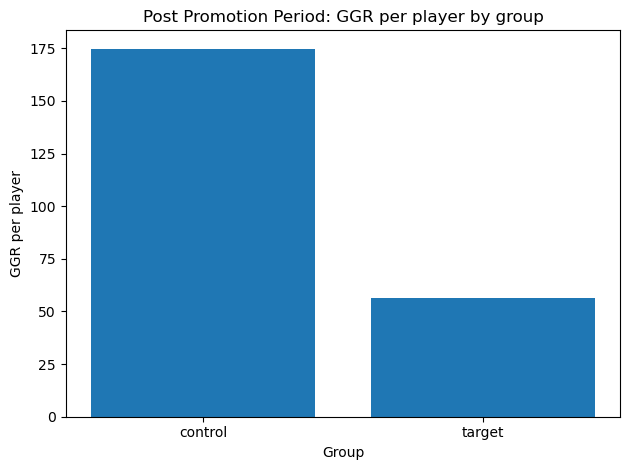

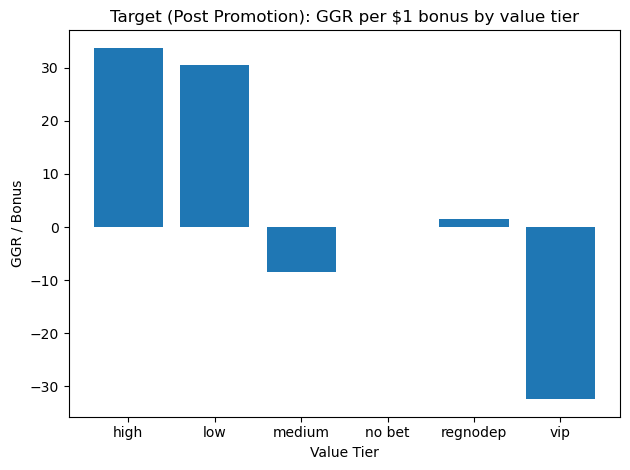

In [76]:
# --- Target-only, POST-period ROI by value tier ---

tpost = post[post['target_control'] == 'target'].copy()

# Aggregate KPIs by value tier:
# - players: distinct players in the tier (POST)
# - ggr_sum: total GGR generated in the tier (pre-bonus)
# - handle_sum: total handle in the tier
tpost_tier = (
    tpost.groupby('last_12months_segment')
         .agg(
             players=('player_id', 'nunique'),
             ggr_sum=('ggr', 'sum'),
             handle_sum=('handle', 'sum')
         )
         .reset_index()
)

# Compute BONUS per tier (POST, Target): count ONE bonus per player, then sum by tier.
# - group by (tier, player) and take first bonus value per player
# - sum across players within the tier
tpost_bonus_tier = (
    tpost.dropna(subset=['bonus_awarded'])
         .groupby(['last_12months_segment', 'player_id'])['bonus_awarded']
         .first()
         .groupby('last_12months_segment')
         .sum()
)

# Tier-level bonus totals; fill tiers with no bonus as 0.0 (shouldn't happen for Target)
tpost_tier['bonus_sum'] = (
    tpost_tier['last_12months_segment'].map(tpost_bonus_tier).fillna(0.0).astype(float)
)

# Net Gaming Revenue (after bonus) by tier
tpost_tier['ngr_sum'] = tpost_tier['ggr_sum'] - tpost_tier['bonus_sum']

# ROI variants by tier:
# - roi_ggr_over_bonus: every $1 of bonus yields $X dollars of GGR (pre-bonus)
# - roi_net_over_bonus: every $1 of bonus yields $X dollars of NGR (post-bonus)
tpost_tier['roi_ggr_over_bonus'] = tpost_tier['ggr_sum'] / tpost_tier['bonus_sum'].replace({0: np.nan})
tpost_tier['roi_net_over_bonus'] = tpost_tier['ngr_sum'] / tpost_tier['bonus_sum'].replace({0: np.nan})
# Replace 0 bonus denominators with NaN to avoid division-by-zero

display("Target (post) ROI by value tier", tpost_tier)

# GGR per player by cohort (POST)
plt.figure()
plt.bar(post_group['target_control'], post_group['ggr_per_player'])
plt.title("Post Promotion Period: GGR per player by group")
plt.xlabel("Group")
plt.ylabel("GGR per player")
plt.tight_layout()
plt.show()

# ROI (GGR per $1 bonus) by value tier (Target, POST)
valid = tpost_tier[tpost_tier['bonus_sum'] > 0]
plt.figure()
plt.bar(valid['last_12months_segment'], valid['roi_ggr_over_bonus'])
plt.title("Target (Post Promotion): GGR per $1 bonus by value tier")
plt.xlabel("Value Tier")
plt.ylabel("GGR / Bonus")
plt.tight_layout()
plt.show()


### Recommendations to CRM (based on post-day results and tier ROI)

**Reallocate budget toward tiers that returned GGR per bonus:**
- **Scale up** in **High** and **Low** tiers (positive GGR/Bonus ratios on promo day).
- **Pause or reduce** in **Medium** and **VIP** tiers (negative returns).
- For these segments, test:
  - **Smaller denominations**,
  - **Capped odds boosts** or **missions** (non-cash constructs that cap downside),
  - **More focused targeting** (recent activity/propensity).

**Guardrails & Monitoring:**
- Add a **stop-loss rule**: if Target per-player GGR underperforms Control by > *X* for *Y* hours, throttle or stop the promo.
- Track **NGR per player** (GGR − Bonus) and **retention rate** alongside GGR, not just raw revenue.

**Testing plan (with a holdout):**
- **Denomination ladders per tier** (e.x., Low: $3 vs $5; High: $15 vs $20).
- **A/B test send-time and creative** experiments focused on High/Low tiers with proven ROI.
- Re-test Medium/VIP only after redesigning incentives; keep a **control** group to measure incremental lift.

**Measurement cleaning:**
- Compute bonus **once per player**, not per row.
- Prefer **post-only per-player** comparisons or **matched-window DiD** for read-outs.
- When **GGR ≤ 0**, report **NGR ($)** and mark net-margin % as **N/A** to avoid misinterpretation.


### Method & Caveats

**Method choices**
- **Bonus accounting:** Count **one bonus per player** (post window) to avoid row-level double counting.
- **Profitability metric:** Compute **NGR = GGR − Bonus**. Show **Net margin after bonus (% of GGR)** only when **GGR > 0**.
- **Read-out:** Use **post-only per-player** Target vs Control to estimate incremental GGR.
- **Segmentation:** Evaluate **ROI by Value Tier** to inform bonus allocation.


##### End of analysis.